In [1]:
import numpy as np
import pandas as pd
import sklearn
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
# tf.disable_v2_behavior()
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pathlib as p
import glob, random, os, warnings
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# # Check for TensorFlow GPU access
# print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.version.VERSION}")
# tf.enable_eager_execution()
print(tf.executing_eagerly())
warnings.filterwarnings('ignore')

TensorFlow version: 2.9.2
True


In [2]:
from PIL import Image
from zipfile import ZipFile
import h5py
import cv2
from tqdm import tqdm
from imgaug import augmenters as iaa

In [3]:
# BATCH_SIZE = 32 # good for your health: https://twitter.com/ylecun/status/989610208497360896
# EPOCHS = 5 # only run for a short period of time... we don't have all day
# DATASET_NAME = "food101" # change this to try other image datasets from TensorFlow Datasets
 # Note: Change this depending on where you're running code

In [4]:
# !kaggle competitions download -c human-protein-atlas-image-classification

In [5]:
# !unzip human-protein-atlas-image-classification.zip

In [6]:
src = "/Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/dataset"
PATH = './'
TRAIN = os.path.join(src, "train")
TEST = os.path.join(src, "test")
LABELS = os.path.join(src, "train.csv")
SAMPLE = os.path.join(src, "sample_submission.csv")
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 32
EPOCHS=5
DEVICE = "Apple M1 Pro"

In [7]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [8]:
dataset_folder = os.path.join(src,"train")
datasetObject = p.Path(dataset_folder)
dataset_images = list(datasetObject.glob("*.*"))
data = pd.read_csv(LABELS)

In [9]:
len(dataset_images)

124288

In [10]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(dataset_folder, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)


In [11]:
# train_names = list({f[:36] for f in os.listdir(TRAIN)})
# test_names = list({f[:36] for f in os.listdir(TEST)})
# tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.2, random_state=42)

In [12]:
# train_ds = pd.read_csv(os.path.join(src, "train.csv"))
# print(train_ds.shape)
# train_ds.head(10)

## Creating a datagenerator which will also transform our images

In [13]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B),-1)
        
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

In [14]:
# test_ds = pd.read_csv(os.path.join(src, "sample_submission.csv"))
# print(test_ds.shape)
# test_ds.head()

In [15]:
# def show_arr(arr, nrows = 1, ncols = 4, figsize=(15, 5)):
#     fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
#     for ii in range(ncols):
#         iplt = subs[ii]
#         try:
#             img_array = arr[:,:,ii]
#             if ii == 0:
#                 cp = 'Greens'
#             elif ii == 1:
#                 cp = 'Blues'
#             elif ii == 2:
#                 cp = 'Reds'
#             else:
#                 cp = 'Oranges'
#             iplt.imshow(img_array, cmap=cp)
#         except:
#             pass

In [16]:
# def get_arr0(Id, test=False):
#     def fn(Id, color, test=False):
#         if test:
#             tgt = 'test'
#         else:
#             tgt = 'train'
#         with open(os.path.join(src, tgt, Id+'_{}.png'.format(color)), 'rb') as fp:
#             img = Image.open(fp)
#             arr = (np.asarray(img) / 255.)
#         return arr
#     res = []
#     for icolor in ['green', 'blue', 'red', 'yellow']:
#         arr0 = fn(Id, icolor, test)
#         res.append(arr0)
#     arr = np.stack(res, axis=-1)
#     return arr

In [17]:
# arr = get_arr0('00008af0-bad0-11e8-b2b8-ac1f6b6435d0', test=True)
# print(arr.shape)
# show_arr(arr)

Since images are in RGB channels, combining them to get the whole picture

In [18]:
# IDs = train_ds['Id']
# plt.figure(figsize = (17, 12))
# for i in range(20):
#   plt.subplot(4, 5, i + 1)
#   red= cv2.imread("dataset/train/{}_red.png".format(str(IDs[i])), 0)
#   green = cv2.imread("dataset/train/{}_green.png".format(str(IDs[i])), 0)
#   blue = cv2.imread("dataset/train/{}_blue.png".format(str(IDs[i])), 0)
#   image = np.stack((red, green, blue), -1)
#   plt.imshow(image)
# plt.show()

In [19]:
train_datagen = data_generator.create_train(
    train_dataset_info, BATCH_SIZE, (299,299,3), augument=True)

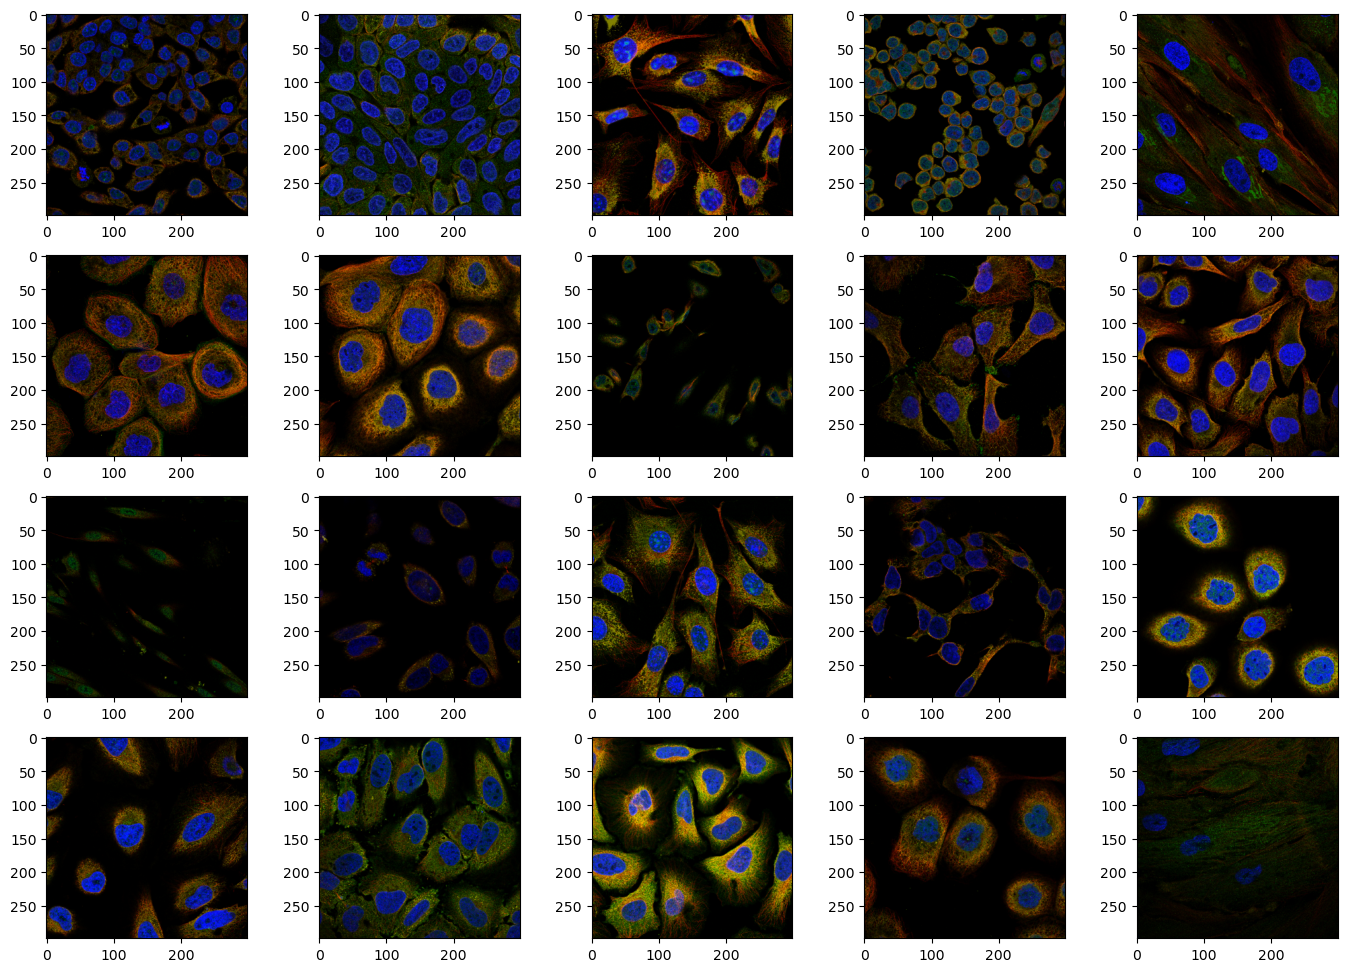

min: 0.0, max: 1.0


In [20]:
images, labels = next(train_datagen)

# fig, ax = plt.subplots(4,5,figsize=(25,5))
plt.figure(figsize = (17, 12))
for i in range(20):
    plt.subplot(4, 5, i + 1)
#     ax[i].imshow(images[i])
    plt.imshow(images[i])
plt.show()
print('min: {0}, max: {1}'.format(images.min(), images.max()))


# IDs = train_ds['Id']
# plt.figure(figsize = (17, 12))
# for i in range(20):
#   plt.subplot(4, 5, i + 1)
#   red= cv2.imread("dataset/train/{}_red.png".format(str(IDs[i])), 0)
#   green = cv2.imread("dataset/train/{}_green.png".format(str(IDs[i])), 0)
#   blue = cv2.imread("dataset/train/{}_blue.png".format(str(IDs[i])), 0)
#   image = np.stack((red, green, blue), -1)
#   plt.imshow(image)
# plt.show()

## Creating our model

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
# import tensorflow as tf
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [22]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [23]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [24]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.summary()

Metal device set to: Apple M1 Pro


2023-01-16 18:36:22.203150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-16 18:36:22.203796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 3)      12        
 ormalization)                                                   
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 128)       262272    
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                             

In [26]:
checkpointer = ModelCheckpoint(
    '/Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['acc', f1])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=5, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/5


2023-01-16 18:39:22.045839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.1770 - acc: 0.3738 - f1: 0.0589

2023-01-16 18:40:27.557292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.17335, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


100/100 [==============================] - 88s 837ms/step - loss: 0.1770 - acc: 0.3738 - f1: 0.0589 - val_loss: 0.1733 - val_acc: 0.3828 - val_f1: 0.0556
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.1756 - acc: 0.3634 - f1: 0.0607
Epoch 2: val_loss improved from 0.17335 to 0.17152, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


100/100 [==============================] - 88s 867ms/step - loss: 0.1756 - acc: 0.3634 - f1: 0.0607 - val_loss: 0.1715 - val_acc: 0.3828 - val_f1: 0.0541
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.1723 - acc: 0.3703 - f1: 0.0619
Epoch 3: val_loss improved from 0.17152 to 0.16802, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


100/100 [==============================] - 88s 869ms/step - loss: 0.1723 - acc: 0.3703 - f1: 0.0619 - val_loss: 0.1680 - val_acc: 0.3828 - val_f1: 0.0560
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.1691 - acc: 0.3744 - f1: 0.0644
Epoch 4: val_loss did not improve from 0.16802
100/100 [==============================] - 67s 659ms/step - loss: 0.1691 - acc: 0.3744 - f1: 0.0644 - val_loss: 0.1681 - val_acc: 0.3711 - val_f1: 0.0597
Epoch 5/5
100/100 [==============================] - ETA: 0s - loss: 0.1715 - acc: 0.3766 - f1: 0.0656
Epoch 5: val_loss improved from 0.16802 to 0.16656, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


100/100 [==============================] - 86s 860ms/step - loss: 0.1715 - acc: 0.3766 - f1: 0.0656 - val_loss: 0.1666 - val_acc: 0.2695 - val_f1: 0.0623


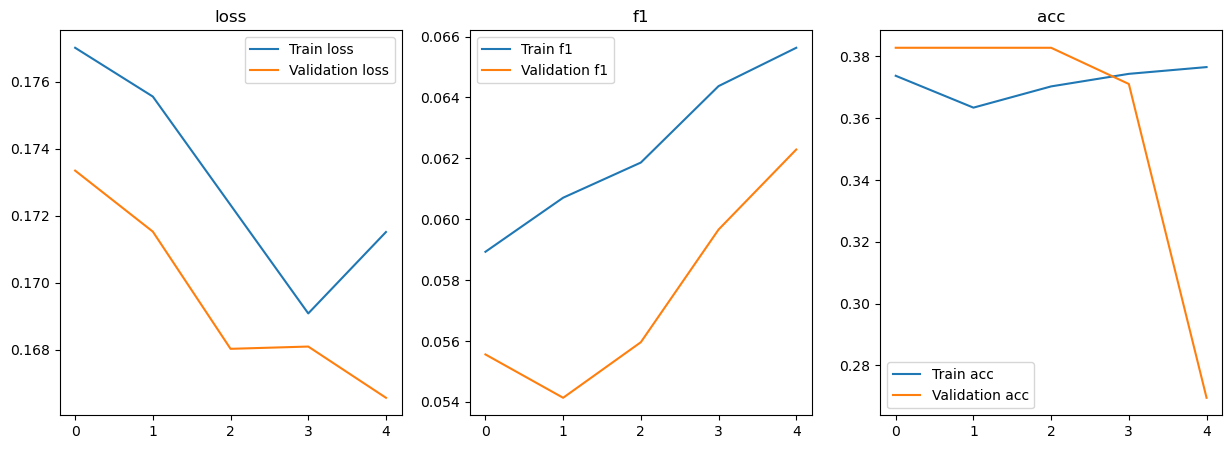

In [27]:
show_history(history)

In [28]:
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = True

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-4),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    validation_data=next(validation_generator),
    epochs=50, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/50


2023-01-16 18:53:14.174927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.1884 - acc: 0.3300 - f1: 0.0642

2023-01-16 18:54:03.243234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss did not improve from 0.16656
50/50 [==============================] - 56s 941ms/step - loss: 0.1884 - acc: 0.3300 - f1: 0.0642 - val_loss: 0.2023 - val_acc: 0.3867 - val_f1: 0.0765
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.1763 - acc: 0.3819 - f1: 0.0659
Epoch 2: val_loss did not improve from 0.16656
50/50 [==============================] - 46s 918ms/step - loss: 0.1763 - acc: 0.3819 - f1: 0.0659 - val_loss: 0.1830 - val_acc: 0.3828 - val_f1: 0.0654
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.1745 - acc: 0.3500 - f1: 0.0654
Epoch 3: val_loss did not improve from 0.16656
50/50 [==============================] - 46s 917ms/step - loss: 0.1745 - acc: 0.3500 - f1: 0.0654 - val_loss: 0.1831 - val_acc: 0.3828 - val_f1: 0.0530
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.1739 - acc: 0.3594 - f1: 0.0679
Epoch 4: val_loss did not improve from 0.16656
50/50 [==============================] - 46s 917m

INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 69s 1s/step - loss: 0.1560 - acc: 0.4181 - f1: 0.0830 - val_loss: 0.1614 - val_acc: 0.4336 - val_f1: 0.0880
Epoch 16/50
50/50 [==============================] - ETA: 0s - loss: 0.1543 - acc: 0.4181 - f1: 0.0843
Epoch 16: val_loss improved from 0.16141 to 0.15873, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 68s 1s/step - loss: 0.1543 - acc: 0.4181 - f1: 0.0843 - val_loss: 0.1587 - val_acc: 0.4375 - val_f1: 0.0905
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 0.1568 - acc: 0.4231 - f1: 0.0870
Epoch 17: val_loss improved from 0.15873 to 0.15265, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 70s 1s/step - loss: 0.1568 - acc: 0.4231 - f1: 0.0870 - val_loss: 0.1527 - val_acc: 0.4453 - val_f1: 0.0903
Epoch 18/50
50/50 [==============================] - ETA: 0s - loss: 0.1519 - acc: 0.4281 - f1: 0.0884
Epoch 18: val_loss improved from 0.15265 to 0.15216, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 71s 1s/step - loss: 0.1519 - acc: 0.4281 - f1: 0.0884 - val_loss: 0.1522 - val_acc: 0.4297 - val_f1: 0.0952
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 0.1562 - acc: 0.4256 - f1: 0.0894
Epoch 19: val_loss improved from 0.15216 to 0.15180, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 70s 1s/step - loss: 0.1562 - acc: 0.4256 - f1: 0.0894 - val_loss: 0.1518 - val_acc: 0.4727 - val_f1: 0.0925
Epoch 20/50
50/50 [==============================] - ETA: 0s - loss: 0.1531 - acc: 0.4281 - f1: 0.0903
Epoch 20: val_loss improved from 0.15180 to 0.14965, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 71s 1s/step - loss: 0.1531 - acc: 0.4281 - f1: 0.0903 - val_loss: 0.1497 - val_acc: 0.4531 - val_f1: 0.0952
Epoch 21/50
50/50 [==============================] - ETA: 0s - loss: 0.1506 - acc: 0.4287 - f1: 0.0942
Epoch 21: val_loss improved from 0.14965 to 0.14879, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 70s 1s/step - loss: 0.1506 - acc: 0.4287 - f1: 0.0942 - val_loss: 0.1488 - val_acc: 0.4492 - val_f1: 0.1009
Epoch 22/50
50/50 [==============================] - ETA: 0s - loss: 0.1537 - acc: 0.4519 - f1: 0.0938
Epoch 22: val_loss improved from 0.14879 to 0.14868, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 69s 1s/step - loss: 0.1537 - acc: 0.4519 - f1: 0.0938 - val_loss: 0.1487 - val_acc: 0.4453 - val_f1: 0.1065
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 0.1503 - acc: 0.4369 - f1: 0.1004
Epoch 23: val_loss improved from 0.14868 to 0.14728, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 70s 1s/step - loss: 0.1503 - acc: 0.4369 - f1: 0.1004 - val_loss: 0.1473 - val_acc: 0.4453 - val_f1: 0.1064
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 0.1505 - acc: 0.4406 - f1: 0.1021
Epoch 24: val_loss improved from 0.14728 to 0.14715, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 70s 1s/step - loss: 0.1505 - acc: 0.4406 - f1: 0.1021 - val_loss: 0.1472 - val_acc: 0.4727 - val_f1: 0.1091
Epoch 25/50
50/50 [==============================] - ETA: 0s - loss: 0.1493 - acc: 0.4419 - f1: 0.0996
Epoch 25: val_loss improved from 0.14715 to 0.14213, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 70s 1s/step - loss: 0.1493 - acc: 0.4419 - f1: 0.0996 - val_loss: 0.1421 - val_acc: 0.4961 - val_f1: 0.1133
Epoch 26/50
50/50 [==============================] - ETA: 0s - loss: 0.1489 - acc: 0.4519 - f1: 0.1019
Epoch 26: val_loss did not improve from 0.14213
50/50 [==============================] - 48s 922ms/step - loss: 0.1489 - acc: 0.4519 - f1: 0.1019 - val_loss: 0.1458 - val_acc: 0.4766 - val_f1: 0.1081
Epoch 27/50
50/50 [==============================] - ETA: 0s - loss: 0.1508 - acc: 0.4512 - f1: 0.1032
Epoch 27: val_loss did not improve from 0.14213
50/50 [==============================] - 46s 917ms/step - loss: 0.1508 - acc: 0.4512 - f1: 0.1032 - val_loss: 0.1484 - val_acc: 0.4531 - val_f1: 0.1079
Epoch 28/50
50/50 [==============================] - ETA: 0s - loss: 0.1444 - acc: 0.4581 - f1: 0.1079
Epoch 28: val_loss did not improve from 0.14213
50/50 [==============================] - 46s 916ms/step - loss: 0.1444 - acc: 0.4581 - f1: 0.1

INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 69s 1s/step - loss: 0.1431 - acc: 0.4644 - f1: 0.1233 - val_loss: 0.1413 - val_acc: 0.5039 - val_f1: 0.1211
Epoch 32/50
50/50 [==============================] - ETA: 0s - loss: 0.1432 - acc: 0.4412 - f1: 0.1196
Epoch 32: val_loss did not improve from 0.14132
50/50 [==============================] - 46s 915ms/step - loss: 0.1432 - acc: 0.4412 - f1: 0.1196 - val_loss: 0.1421 - val_acc: 0.5117 - val_f1: 0.1235
Epoch 33/50
50/50 [==============================] - ETA: 0s - loss: 0.1454 - acc: 0.4737 - f1: 0.1171
Epoch 33: val_loss did not improve from 0.14132
50/50 [==============================] - 46s 913ms/step - loss: 0.1454 - acc: 0.4737 - f1: 0.1171 - val_loss: 0.1438 - val_acc: 0.4570 - val_f1: 0.1223
Epoch 34/50
50/50 [==============================] - ETA: 0s - loss: 0.1389 - acc: 0.4675 - f1: 0.1268
Epoch 34: val_loss did not improve from 0.14132
50/50 [==============================] - 45s 911ms/step - loss: 0.1389 - acc: 0.4675 - f1: 0.1

INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 69s 1s/step - loss: 0.1425 - acc: 0.4475 - f1: 0.1226 - val_loss: 0.1383 - val_acc: 0.4961 - val_f1: 0.1241
Epoch 37/50
50/50 [==============================] - ETA: 0s - loss: 0.1375 - acc: 0.4519 - f1: 0.1300
Epoch 37: val_loss improved from 0.13834 to 0.13695, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 69s 1s/step - loss: 0.1375 - acc: 0.4519 - f1: 0.1300 - val_loss: 0.1370 - val_acc: 0.4375 - val_f1: 0.1290
Epoch 38/50
50/50 [==============================] - ETA: 0s - loss: 0.1371 - acc: 0.4806 - f1: 0.1253
Epoch 38: val_loss did not improve from 0.13695
50/50 [==============================] - 46s 914ms/step - loss: 0.1371 - acc: 0.4806 - f1: 0.1253 - val_loss: 0.1387 - val_acc: 0.4922 - val_f1: 0.1289
Epoch 39/50
50/50 [==============================] - ETA: 0s - loss: 0.1332 - acc: 0.4794 - f1: 0.1326
Epoch 39: val_loss did not improve from 0.13695
50/50 [==============================] - 45s 909ms/step - loss: 0.1332 - acc: 0.4794 - f1: 0.1326 - val_loss: 0.1380 - val_acc: 0.5000 - val_f1: 0.1308
Epoch 40/50
50/50 [==============================] - ETA: 0s - loss: 0.1351 - acc: 0.4550 - f1: 0.1322
Epoch 40: val_loss improved from 0.13695 to 0.13573, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/Res

INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 69s 1s/step - loss: 0.1351 - acc: 0.4550 - f1: 0.1322 - val_loss: 0.1357 - val_acc: 0.4922 - val_f1: 0.1311
Epoch 41/50
50/50 [==============================] - ETA: 0s - loss: 0.1367 - acc: 0.4806 - f1: 0.1318
Epoch 41: val_loss improved from 0.13573 to 0.13412, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 68s 1s/step - loss: 0.1367 - acc: 0.4806 - f1: 0.1318 - val_loss: 0.1341 - val_acc: 0.5000 - val_f1: 0.1373
Epoch 42/50
50/50 [==============================] - ETA: 0s - loss: 0.1355 - acc: 0.4750 - f1: 0.1338
Epoch 42: val_loss did not improve from 0.13412
50/50 [==============================] - 45s 907ms/step - loss: 0.1355 - acc: 0.4750 - f1: 0.1338 - val_loss: 0.1386 - val_acc: 0.4844 - val_f1: 0.1332
Epoch 43/50
50/50 [==============================] - ETA: 0s - loss: 0.1387 - acc: 0.5012 - f1: 0.1380
Epoch 43: val_loss did not improve from 0.13412
50/50 [==============================] - 45s 908ms/step - loss: 0.1387 - acc: 0.5012 - f1: 0.1380 - val_loss: 0.1347 - val_acc: 0.5000 - val_f1: 0.1397
Epoch 44/50
50/50 [==============================] - ETA: 0s - loss: 0.1374 - acc: 0.4644 - f1: 0.1354
Epoch 44: val_loss did not improve from 0.13412
50/50 [==============================] - 46s 914ms/step - loss: 0.1374 - acc: 0.4644 - f1: 0.1

INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 68s 1s/step - loss: 0.1363 - acc: 0.4612 - f1: 0.1418 - val_loss: 0.1328 - val_acc: 0.5000 - val_f1: 0.1401
Epoch 47/50
50/50 [==============================] - ETA: 0s - loss: 0.1344 - acc: 0.4944 - f1: 0.1470
Epoch 47: val_loss did not improve from 0.13280
50/50 [==============================] - 46s 915ms/step - loss: 0.1344 - acc: 0.4944 - f1: 0.1470 - val_loss: 0.1408 - val_acc: 0.4375 - val_f1: 0.1393
Epoch 48/50
50/50 [==============================] - ETA: 0s - loss: 0.1284 - acc: 0.5056 - f1: 0.1422
Epoch 48: val_loss did not improve from 0.13280
50/50 [==============================] - 46s 914ms/step - loss: 0.1284 - acc: 0.5056 - f1: 0.1422 - val_loss: 0.1354 - val_acc: 0.5078 - val_f1: 0.1376
Epoch 49/50
50/50 [==============================] - ETA: 0s - loss: 0.1311 - acc: 0.4975 - f1: 0.1496
Epoch 49: val_loss improved from 0.13280 to 0.13172, saving model to /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/Res

INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ResNet50.model/assets


50/50 [==============================] - 69s 1s/step - loss: 0.1311 - acc: 0.4975 - f1: 0.1496 - val_loss: 0.1317 - val_acc: 0.4961 - val_f1: 0.1507
Epoch 50/50
50/50 [==============================] - ETA: 0s - loss: 0.1324 - acc: 0.5094 - f1: 0.1448
Epoch 50: val_loss did not improve from 0.13172
50/50 [==============================] - 47s 917ms/step - loss: 0.1324 - acc: 0.5094 - f1: 0.1448 - val_loss: 0.1349 - val_acc: 0.4922 - val_f1: 0.1415


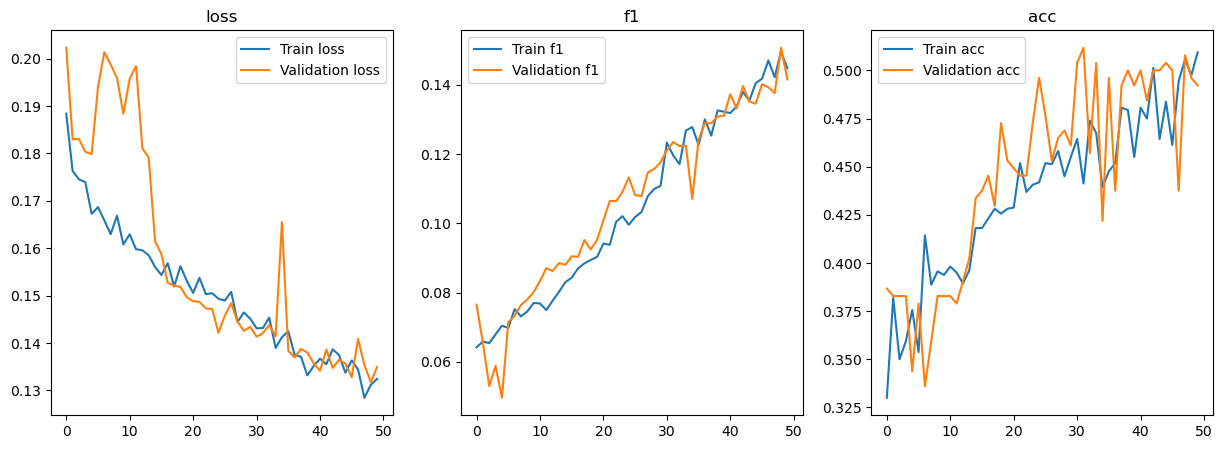

In [29]:
show_history(history)

# Implementing Visual Transformer

In [30]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.relu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [31]:
from tensorflow.keras import layers

class ImagePatches(layers.Layer):
    def __init__(self, patch_size):
        super(ImagePatches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [32]:
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

## Displaying the image in patches

Image size: 75 X 75
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


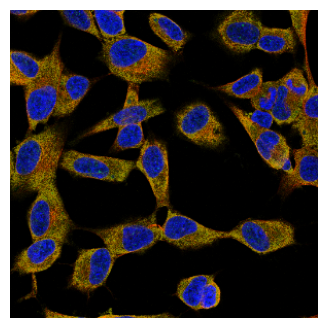

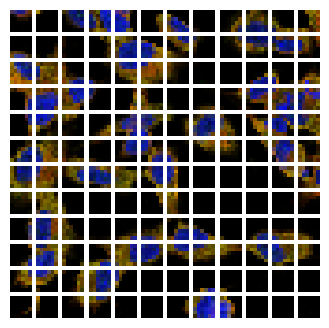

In [33]:
# tf.compat.v1.enable_v2_behavior
from torchvision import transforms
# tf.enable_eager_execution()
# tf.compat.v1.enable_eager_execution()

plt.figure(figsize=(4, 4))
plt.axis("off")
image, labels = next(train_generator)
patch_size = 6
image_size = 75

idx = np.random.choice(range(1, 25))
image = image[idx]
plt.imshow(image)

image = image.reshape(1, 299, 299, 3)

resized_image = tf.image.resize(
    tf.convert_to_tensor(image),
    size = (image_size, image_size)
)

# print("resized_image shape: ", image.shape)
patches = ImagePatches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

ps = patches.get_shape().as_list()[1]
px = tf.unstack(patches[0])

n = int(np.sqrt(ps))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(px):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    patch_img = patch_img.numpy()
#     patch_img = patch.view(patch_size, patch_size, 3)
#     patch=patch.numpy()
    plt.imshow(patch_img)
    plt.axis("off")


## Implementing Path Encoder

In [34]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Making a vanilla ViT Classifier

In [41]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(inputs)

2023-01-16 19:55:13.826745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-16 19:55:13.850508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [42]:
transform_layers = 8

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

In [43]:
inputs, labels = next(train_generator)
inputs.shape
labels.shape

(32, 28)

In [44]:
input_shape = (299, 299, 3)
num_patches = (image_size // patch_size) ** 2
projection_dim = 28
num_heads = 4
transformer_layers = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
num_classes = 28
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5

def create_vit_classifier():
    inputs = layers.Input(shape=(input_shape))
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = ImagePatches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
#     logits = layers.Dense(28, activation='sigmoid')(features)
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    Vmodel = keras.Model(inputs=inputs, outputs=logits)
    return Vmodel

In [45]:
def vision_transformer():
    inputs = layers.Input(shape = (299, 299, 3))
    
    # Create patches.
    patches = ImagePatches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [46]:
image.shape

(1, 299, 299, 3)

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 3)      12        
 ormalization)                                                   
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 128)       262272    
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                             

In [48]:
image.shape

(1, 299, 299, 3)

In [49]:
labels.shape

(32, 28)

In [50]:
labels

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[
#             keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
#         ],
    )

    checkpoint_filepath = "'/Users/tanmay/IITG-2022/7th-Sem/DLWCV/Human Protein Atlas/checkpoints/ViT.model',"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    image, labels = next(train_generator)
    labels = np.array(labels)
    history = model.fit(
#         x=train_generator,
#         validation_data=validation_generator,
#         batch_size=batch_size,
#         epochs=5,
#         validation_split=0.1,
#         callbacks=[checkpoint_callback],
        x=image,
        y=labels,
        batch_size=batch_size,
        epochs=5,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
        
#         x=x_train,
#         y=y_train,
#         batch_size=batch_size,
#         epochs=5,
#         validation_split=0.1,
#         callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
#     _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#     print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


# vit_classifier = create_vit_classifier()
vit_vlassifier = vision_transformer()
history = run_experiment(vit_vlassifier)

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    return image

In [ ]:
df_train = pd.read_csv(LABELS, dtype = 'str')

test_images = glob.glob(TEST + '/*.jpg')

df_test = pd.DataFrame(test_images, columns = ['ID'])

In [ ]:
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center = True,
#                                                           samplewise_std_normalization = True,
#                                                           validation_split = 0.2,
#                                                           preprocessing_function = data_augment)

# train_gen = datagen.flow_from_dataframe(dataframe = df_train,
#                                         directory = TRAIN,
#                                         x_col = 'ID',
#                                         y_col = 'Label',
#                                         subset = 'training',
#                                         batch_size = batch_size,
#                                         seed = 1,
#                                         shuffle = True,
#                                         class_mode = 'categorical',
#                                         target_size = (image_size, image_size))

# valid_gen = datagen.flow_from_dataframe(dataframe = df_train,
#                                         directory = TRAIN,
#                                         x_col = 'ID',
#                                         y_col = 'Label',
#                                         subset = 'validation',
#                                         batch_size = batch_size,
#                                         seed = 1,
            
#                                         shuffle = False,
#                                         class_mode = 'categorical',
#                                         target_size = (image_size, image_size))

# test_gen = datagen.flow_from_dataframe(dataframe = df_test,
#                                        x_col = 'ID',
#                                        y_col = None,
#                                        batch_size = batch_size,
#                                        seed = 1,
#                                        color_mode = 'rgb',
#                                        shuffle = False,
#                                        class_mode = None,
#                                        target_size = (image_size, image_size))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# model = vision_transformer()
model = create_vit_classifier()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])


# STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
# STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

# callbacks = [earlystopping, lr_scheduler, checkpointer]
callbacks = [checkpointer]

model.fit(x = train_datagen,
#           steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_datagen,
#           validation_steps = STEP_SIZE_VALID,
          epochs = num_epochs,
          callbacks = callbacks)